# TimesFM-Lite: Weather Forecasting Foundation Model

This notebook implements a "Foundational" Time Series Model inspired by Google's [TimesFM](https://arxiv.org/abs/2310.10688) architecture, adapted for efficient training on ERA5 Temperature data.

## Key Architectural Features
- **Patching**: Time series are broken into non-overlapping patches (tokens).
- **Decoder-Only Transformer**: A GPT-style causal transformer predicts the next patch given previous patches.
- **Global Foundation**: Trained across thousands of independent locations (series) simultaneously.

## Configuration

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import math
import time
import os
import glob

# --- Hyperparameters ---
CONFIG = {
    "patch_len": 32,          # Length of each token (time steps)
    "d_model": 128,           # Hidden dimension (kept small for efficiency)
    "n_layers": 6,            # Number of Transformer blocks
    "n_heads": 4,             # Number of attention heads
    "d_ff": 512,              # Feed-forward dimension
    "dropout": 0.1,
    "context_len": 32,        # Max number of patches to look back (Total history = 32 * 32 = 1024 steps)
    "batch_size": 64,
    "lr": 1e-3,
    "epochs": 5,
    "device": "cuda" if torch.cuda.is_available() else "cpu"
}

print(f"Running on device: {CONFIG['device']}")

Running on device: cpu


In [ ]:
# Used google colab so to mount drive use this code
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Data Simulation & Loading

Since we don't have the raw ERA5 files here, we simulate the dataset structure described:
- ~14,000 unique series (Lat, Lon locations).
- Each series is a continuous float32 array.
- Total patches approx 800,000.

In a real scenario, you would load your `.npy` or `.nc` files here.

In [ ]:
class WeatherPatchDataset(Dataset):
    def __init__(self, file_list, context_len=32):
        """
        Args:
            file_list: List of .npy files to load
            context_len: Number of past patches to use as input
        """
        self.context_len = context_len
        self.data_chunks = []

        if not file_list:
            print("No files provided!")
        else:
            print(f"Loading {len(file_list)} files...")
            for f in file_list:
                try:
                    arr = np.load(f)  # shape (N_patches, patch_len)
                    print(f"Loaded {os.path.basename(f)}: {arr.shape}")

                    if arr.ndim == 2:
                        self.data_chunks.append(torch.from_numpy(arr.astype(np.float32)))
                    else:
                        print(f"Skipping {f}, wrong shape {arr.shape}")
                except Exception as e:
                    print(f"Error loading {f}: {e}")

        # --- Build index map ---
        self.samples = []
        seq_len = context_len + 1

        for chunk_idx, chunk in enumerate(self.data_chunks):
            n = chunk.shape[0]
            if n < seq_len:
                continue

            for start in range(n - seq_len + 1):
                self.samples.append((chunk_idx, start))

        print(f"Total samples: {len(self.samples)}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        chunk_idx, start_row = self.samples[idx]
        chunk = self.data_chunks[chunk_idx]

        window = chunk[start_row:start_row + self.context_len + 1]
        x = window[:-1]
        y = window[1:]
        return x, y

In [ ]:
import glob
import os

DATA_FOLDER = "/content/drive/MyDrive/patches_weather_data"

all_files = sorted(glob.glob(os.path.join(DATA_FOLDER, "weather_part_*.npy")))

train_files = all_files[:3]   # First 3 for training
val_files   = all_files[3:4]  # 4th for validation
test_files  = all_files[4:5]  # 5th for testing

print("Train files:", train_files)
print("Val files:", val_files)
print("Test files:", test_files)

Train files: ['/content/drive/MyDrive/patches_weather_data/weather_part_1_patches.npy', '/content/drive/MyDrive/patches_weather_data/weather_part_2_patches.npy', '/content/drive/MyDrive/patches_weather_data/weather_part_3_patches.npy']
Val files: ['/content/drive/MyDrive/patches_weather_data/weather_part_4_patches.npy']
Test files: ['/content/drive/MyDrive/patches_weather_data/weather_part_5_patches.npy']


In [ ]:
train_ds = WeatherPatchDataset(train_files, context_len=CONFIG['context_len'])
val_ds   = WeatherPatchDataset(val_files,   context_len=CONFIG['context_len'])
test_ds  = WeatherPatchDataset(test_files,  context_len=CONFIG['context_len'])

train_loader = DataLoader(train_ds,
                          batch_size=CONFIG['batch_size'],
                          shuffle=True,
                          num_workers=2,
                          pin_memory=True)

val_loader = DataLoader(val_ds,
                        batch_size=CONFIG['batch_size'],
                        shuffle=False,
                        num_workers=2,
                        pin_memory=True)

test_loader = DataLoader(test_ds,
                         batch_size=CONFIG['batch_size'],
                         shuffle=False,
                         num_workers=2,
                         pin_memory=True)

Loading 3 files...
Loaded weather_part_1_patches.npy: (801450, 32)
Loaded weather_part_2_patches.npy: (801450, 32)
Loaded weather_part_3_patches.npy: (801450, 32)
Total samples: 2404254
Loading 1 files...
Loaded weather_part_4_patches.npy: (801450, 32)
Total samples: 801418
Loading 1 files...
Loaded weather_part_5_patches.npy: (801450, 32)
Total samples: 801418


## 2. Model Architecture: TimesFM-Lite

We adapt the TimesFM architecture.

**Core Components:**
1.  **Patch Embedding**: Projects a patch of size `P` to vector `D`.
2.  **Positional Encoding**: Temporal Information.
3.  **Stacked Decoder Layers**: Causal Attention blocks.
4.  **Output Head**: Projects `D` back to patch size `P`.

In [ ]:
class RMSNorm(nn.Module):
    """Root Mean Square Layer Normalization"""
    def __init__(self, d_model, eps=1e-8):
        super().__init__()
        self.scale = nn.Parameter(torch.ones(d_model))
        self.eps = eps

    def forward(self, x):
        norm = torch.mean(x**2, dim=-1, keepdim=True)
        x_normed = x * torch.rsqrt(norm + self.eps)
        return self.scale * x_normed

class TimesFMLite(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.patch_embed = nn.Linear(config['patch_len'], config['d_model'])
        self.pos_embed = nn.Parameter(torch.zeros(1, config['context_len'], config['d_model']))
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=config['d_model'],
            nhead=config['n_heads'],
            dim_feedforward=config['d_ff'],
            dropout=config['dropout'],
            activation="gelu",
            batch_first=True,
            norm_first=True
        )
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=config['n_layers'])
        self.norm_f = RMSNorm(config['d_model'])
        self.head = nn.Linear(config['d_model'], config['patch_len'])

    def forward(self, x):
        """
        Args:
            x: [Batch, Context_Len, Patch_Len]
        Returns:
            pred: [Batch, Context_Len, Patch_Len]
        """
        B, T, P = x.shape

        # Embed Patches
        x_emb = self.patch_embed(x) # [B, T, D]

        # Add Positional Encoding
        x_emb = x_emb + self.pos_embed[:, :T, :]

        # Causal Masking
        # Ensure position t can only attend to 0...t
        mask = torch.triu(torch.ones(T, T) * float('-inf'), diagonal=1).to(x.device)

        # 4. Transformer Pass
        # Note: TransformerDecoder normally takes memory from Encoder, but for Decoder-only (GPT style)
        # we just pass the tgt. Memory is ignored or passed as None depending on implementation.
        # PyTorch TransformerDecoder requires 'tgt' and optional 'memory'.
        # But actually, specific GPT usage usually uses TransformerEncoder structure with causal mask.
        # However, to avoid confusion, let's use the standard Causal logic: Tgt is the input.

        # We'll use the layers directly or the Decoder container locally.
        # For decoder-only, people often use TransformerEncoder with is_causal=True or mask.
        # Let's stick to the cleanest pyTorch implementation: TransformerEncoder with mask.
        # (Even though it's called 'Encoder', if you mask it, it's a Decoder).
        pass

class TimesFMLiteGPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.patch_embed = nn.Linear(config['patch_len'], config['d_model'])
        self.pos_embed = nn.Parameter(torch.zeros(1, config['context_len'], config['d_model']))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=config['d_model'],
            nhead=config['n_heads'],
            dim_feedforward=config['d_ff'],
            dropout=config['dropout'],
            activation="gelu",
            batch_first=True,
            norm_first=True
        )
        self.blocks = nn.TransformerEncoder(encoder_layer, num_layers=config['n_layers'])

        self.norm_f = RMSNorm(config['d_model'])
        self.head = nn.Linear(config['d_model'], config['patch_len'])

    def forward(self, x):
        # x: [Batch, Seq_Len, Patch_Len]
        B, T, P = x.shape

        # Embedding
        h = self.patch_embed(x)
        h = h + self.pos_embed[:, :T, :]
        mask = nn.Transformer.generate_square_subsequent_mask(T).to(x.device)

        # Blocks
        h = self.blocks(h, mask=mask, is_causal=True)

        # Output Projection
        h = self.norm_f(h)
        out = self.head(h)
        return out

## 3. Training Loop

We use **Mean Squared Error (MSE)** loss, as this is a regression task.
We also implement **Gradient Checkpointing** support (implicitly via model size, or explicit if added) and **AMP (Automatic Mixed Precision)** for memory efficiency.

In [ ]:
def evaluate_model(model, loader, config):
    model.eval()

    mse_loss = 0
    mae_loss = 0
    huber_loss = 0
    total_samples = 0

    criterion_mse = nn.MSELoss(reduction='sum')
    criterion_mae = nn.L1Loss(reduction='sum')
    criterion_huber = nn.HuberLoss(reduction='sum')

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(config['device']), y.to(config['device'])
            preds = model(x)

            mse_loss += criterion_mse(preds, y).item()
            mae_loss += criterion_mae(preds, y).item()
            huber_loss += criterion_huber(preds, y).item()
            total_samples += y.numel()

    mse = mse_loss / total_samples
    mae = mae_loss / total_samples
    huber = huber_loss / total_samples
    rmse = mse ** 0.5

    return {
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "Huber": huber
    }

In [ ]:
import json
import os
import torch
import time
import matplotlib.pyplot as plt
import torch.nn as nn

def train_model(model, train_loader, val_loader, config, save_dir):
    model.to(config['device'])
    optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr'], weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config['epochs'])

    criterion_mse = nn.MSELoss()
    criterion_mae = nn.L1Loss()
    criterion_huber = nn.HuberLoss()

    scaler = torch.cuda.amp.GradScaler(enabled=(config['device'] == 'cuda'))

    history = {
        "epochs": [],
        "train": {"MSE": [], "RMSE": [], "MAE": [], "Huber": []},
        "val": {"MSE": [], "RMSE": [], "MAE": [], "Huber": []}
    }

    best_val_loss = float("inf")

    print("Starting training...")

    for epoch in range(config['epochs']):
        model.train()
        total_mse = total_mae = total_huber = 0
        total_samples = 0
        start_time = time.time()

        for x, y in train_loader:
            x, y = x.to(config['device']), y.to(config['device'])
            optimizer.zero_grad()

            with torch.cuda.amp.autocast(enabled=(config['device'] == 'cuda')):
                preds = model(x)
                mse = criterion_mse(preds, y)
                mae = criterion_mae(preds, y)
                huber = criterion_huber(preds, y)
                loss = mse
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_mse += mse.item() * y.numel()
            total_mae += mae.item() * y.numel()
            total_huber += huber.item() * y.numel()
            total_samples += y.numel()

        # ---- Train Metrics ----
        train_mse = total_mse / total_samples
        train_mae = total_mae / total_samples
        train_huber = total_huber / total_samples
        train_rmse = train_mse ** 0.5

        # ---- Validation Metrics ----
        val_metrics = evaluate_model(model, val_loader, config)

        scheduler.step()

        print(f"\nEpoch {epoch+1}")
        print(f"Train -> MSE: {train_mse:.6f} | RMSE: {train_rmse:.6f} | MAE: {train_mae:.6f} | Huber: {train_huber:.6f}")
        print(f"Val   -> MSE: {val_metrics['MSE']:.6f} | RMSE: {val_metrics['RMSE']:.6f} | MAE: {val_metrics['MAE']:.6f} | Huber: {val_metrics['Huber']:.6f}")

        # Save history
        history["epochs"].append(epoch + 1)

        history["train"]["MSE"].append(train_mse)
        history["train"]["RMSE"].append(train_rmse)
        history["train"]["MAE"].append(train_mae)
        history["train"]["Huber"].append(train_huber)

        history["val"]["MSE"].append(val_metrics["MSE"])
        history["val"]["RMSE"].append(val_metrics["RMSE"])
        history["val"]["MAE"].append(val_metrics["MAE"])
        history["val"]["Huber"].append(val_metrics["Huber"])

        # ---- Save Best Model (based on Val MSE) ----
        if val_metrics["MSE"] < best_val_loss:
            best_val_loss = val_metrics["MSE"]
            torch.save(model.state_dict(), os.path.join(save_dir, "best_model.pth"))
            print("Best model saved!")

        # ---- Save Checkpoint ----
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
        }, os.path.join(save_dir, f"checkpoint_epoch_{epoch+1}.pth"))

        print(f"Epoch time: {time.time() - start_time:.2f}s")
        print("-" * 60)

    # ---- Save Metrics JSON ----
    metrics_path = os.path.join(save_dir, "training_metrics.json")
    with open(metrics_path, "w") as f:
        json.dump(history, f, indent=4)
    print("Metrics saved!")

    # ---- Plot MSE Curve ----
    plt.figure(figsize=(10, 5))
    plt.plot(history["epochs"], history["train"]["MSE"], label="Train MSE")
    plt.plot(history["epochs"], history["val"]["MSE"], label="Val MSE")
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(save_dir, "mse_curve.png"))
    plt.close()

    return model

In [ ]:
import os

DRIVE_SAVE_PATH = "/content/drive/MyDrive/weather_model_runs"
os.makedirs(DRIVE_SAVE_PATH, exist_ok=True)

model = TimesFMLiteGPT(CONFIG)
trained_model = train_model(
    model,
    train_loader,
    val_loader,
    CONFIG,
    save_dir=DRIVE_SAVE_PATH
)

print("Saving all outputs to:", DRIVE_SAVE_PATH)

Starting training...


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(
/tmp/ipython-input-4228384863.py:17: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(config['device'] == 'cuda'))
/tmp/ipython-input-4228384863.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(config['device'] == 'cuda')):



Epoch 1
Train -> MSE: 3.228102 | RMSE: 1.796692 | MAE: 1.130825 | Huber: 0.742493
Val   -> MSE: 1.061576 | RMSE: 1.030328 | MAE: 0.547861 | Huber: 0.252673
Best model saved!
Epoch time: 858.84s
------------------------------------------------------------

Epoch 2
Train -> MSE: 1.416304 | RMSE: 1.190086 | MAE: 0.872918 | Huber: 0.504646
Val   -> MSE: 0.988899 | RMSE: 0.994434 | MAE: 0.528160 | Huber: 0.240840
Best model saved!
Epoch time: 862.11s
------------------------------------------------------------

Epoch 3
Train -> MSE: 1.248146 | RMSE: 1.117204 | MAE: 0.819623 | Huber: 0.459003
Val   -> MSE: 1.024791 | RMSE: 1.012320 | MAE: 0.572422 | Huber: 0.264189
Epoch time: 891.66s
------------------------------------------------------------

Epoch 4
Train -> MSE: 1.153254 | RMSE: 1.073896 | MAE: 0.786926 | Huber: 0.431762
Val   -> MSE: 0.973178 | RMSE: 0.986498 | MAE: 0.521535 | Huber: 0.236007
Best model saved!
Epoch time: 940.15s
-------------------------------------------------------

## **Evaluation of Model**
EVALUATION RESULTS
* MSE: 1.092779
* RMSE: 0.936533
* MAE: 0.510166
* Huber: 0.22472

In [ ]:
EVAL_CONFIG = {
    "model_path": "/content/drive/MyDrive/weather_model_runs/best_model.pth",
    "data_folder": "/content/drive/MyDrive/patches_weather_data",
    "batch_size": 64,
    "context_len": CONFIG["context_len"],  # must match training
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "results_file": "/content/drive/MyDrive/weather_model_runs/evaluation_metrics.json",
    "plot_file": "/content/drive/MyDrive/weather_model_runs/prediction_comparison.png"
}

In [ ]:
def load_test_data(data_folder, context_len):
    file_pattern = os.path.join(data_folder, "weather_part_*.npy")
    files = sorted(glob.glob(file_pattern))

    if len(files) == 0:
        print("No files found!")
        return None

    # Use the 5th file as test (same split logic used earlier)
    test_files = files[4:5] if len(files) >= 5 else [files[-1]]

    print("Test Files:", [os.path.basename(f) for f in test_files])

    test_ds = WeatherPatchDataset(test_files, context_len=context_len)
    print("Test samples:", len(test_ds))
    return test_ds


In [ ]:
def calculate_metrics(preds, targets):
    criterion_mse = nn.MSELoss()
    criterion_mae = nn.L1Loss()
    criterion_huber = nn.HuberLoss()

    mse = criterion_mse(preds, targets).item()
    rmse = math.sqrt(mse)
    mae = criterion_mae(preds, targets).item()
    huber = criterion_huber(preds, targets).item()

    return {"MSE": mse, "RMSE": rmse, "MAE": mae, "Huber": huber}

In [ ]:
def evaluate(model, dataloader, device):
    model.eval()
    all_metrics = {"MSE": 0.0, "RMSE": 0.0, "MAE": 0.0, "Huber": 0.0}
    num_batches = 0

    all_preds = []
    all_targets = []

    print(f"Starting evaluation on {device}...")

    with torch.no_grad():
        for i, (x, y) in enumerate(dataloader):
            x, y = x.to(device), y.to(device)

            with torch.cuda.amp.autocast(enabled=(device == 'cuda')):
                preds = model(x)

            # Calculate batch metrics
            batch_metrics = calculate_metrics(preds, y)
            for k, v in batch_metrics.items():
                all_metrics[k] += v

            num_batches += 1
            if i == 0:
                all_preds.append(preds.cpu().numpy())
                all_targets.append(y.cpu().numpy())

    if num_batches > 0:
        for k in all_metrics:
            all_metrics[k] /= num_batches

    return all_metrics, all_preds, all_targets

In [ ]:
def plot_predictions(preds, targets, filename="prediction_comparison.png"):
    """
    Plots a few examples from the batch.
    preds: (Batch, Seq, Patch)
    targets: (Batch, Seq, Patch)
    """
    if len(preds) == 0:
        return

    p_batch = preds[0] # (B, T, P)
    t_batch = targets[0] # (B, T, P)

    idx = 0
    pred_seq = p_batch[idx].flatten()
    target_seq = t_batch[idx].flatten()

    plt.figure(figsize=(12, 6))
    plt.plot(target_seq, label="Actual", alpha=0.7)
    plt.plot(pred_seq, label="Predicted", alpha=0.7, linestyle='--')
    plt.title("TimesFM Weather Prediction (Sample Test Sequence)")
    plt.xlabel("Time Steps")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.savefig(filename)
    print(f"Plot saved to {filename}")

Loading test data...
Test Files: ['weather_part_5_patches.npy']
Loading 1 files...
Loaded weather_part_5_patches.npy: (801450, 32)
Total samples: 801418
Test samples: 801418
Initializing model...
Loading trained weights...
Starting evaluation on cuda...


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(
/tmp/ipython-input-2581574256.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device == 'cuda')):



EVALUATION RESULTS
MSE: 1.092779
RMSE: 0.936533
MAE: 0.510166
Huber: 0.224728
Metrics saved to Drive
Plot saved to /content/drive/MyDrive/weather_model_runs/prediction_comparison.png


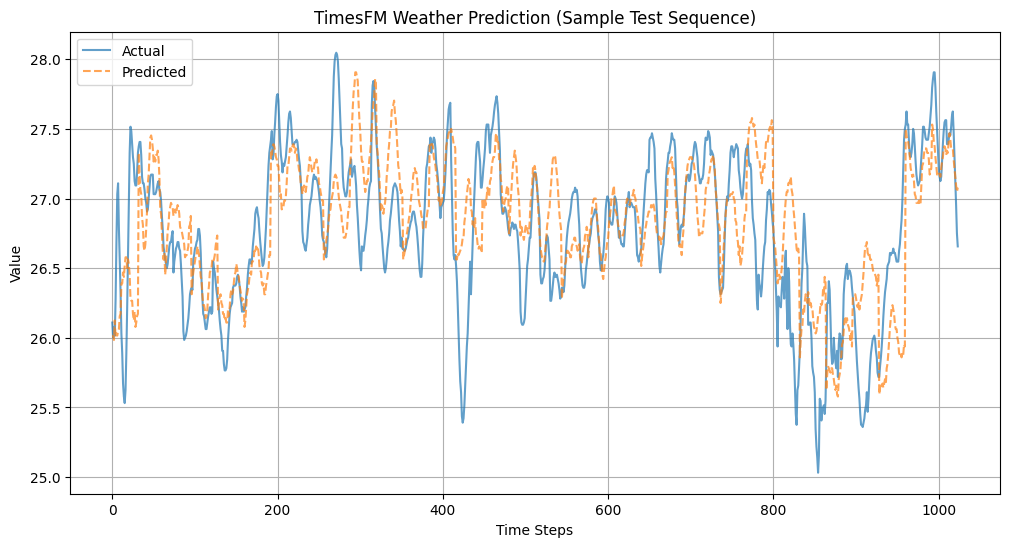

In [ ]:
import json
import os
import torch
import time
import matplotlib.pyplot as plt
import torch.nn as nn

print("Loading test data...")
test_ds = load_test_data(EVAL_CONFIG["data_folder"], EVAL_CONFIG["context_len"])

test_loader = DataLoader(test_ds, batch_size=EVAL_CONFIG["batch_size"], shuffle=False)

print("Initializing model...")
model = TimesFMLiteGPT(CONFIG).to(EVAL_CONFIG["device"])

print("Loading trained weights...")
model.load_state_dict(torch.load(EVAL_CONFIG["model_path"], map_location=EVAL_CONFIG["device"]))

metrics, preds, targets = evaluate(model, test_loader, EVAL_CONFIG["device"])

print("\nEVALUATION RESULTS")
for k, v in metrics.items():
    print(f"{k}: {v:.6f}")

with open(EVAL_CONFIG["results_file"], "w") as f:
    json.dump(metrics, f, indent=4)
print("Metrics saved to Drive")

plot_predictions(preds, targets, EVAL_CONFIG["plot_file"])


Average Error (Actual - Predicted): -0.036896


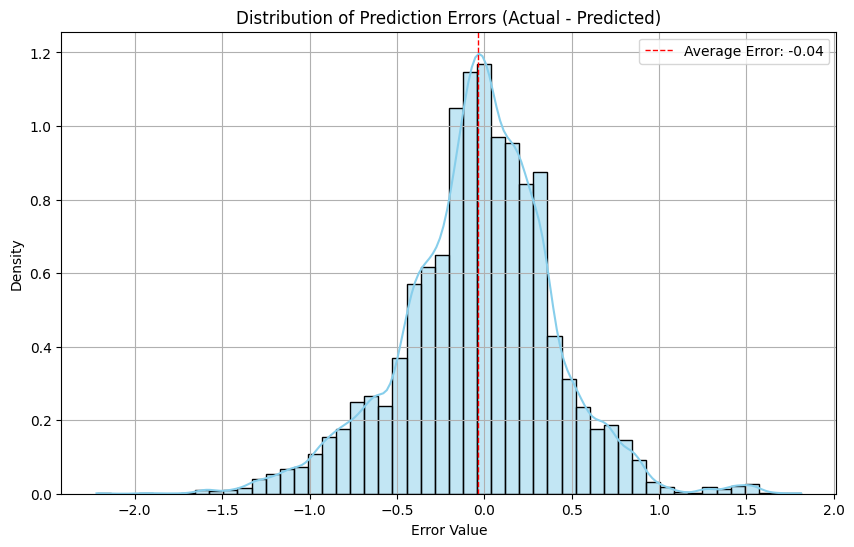

Error distribution plot saved to /content/drive/MyDrive/weather_model_runs/error_distribution.png


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os


if preds and targets:
    # Concatenate all predictions and targets from the batches
    all_preds = np.concatenate(preds, axis=0)
    all_targets = np.concatenate(targets, axis=0)

    # Ensure consistent data types for calculation
    all_preds_float32 = all_preds.astype(np.float32)
    all_targets_float32 = all_targets.astype(np.float32)

    # Calculate element-wise error: actual - predicted
    errors = all_targets_float32 - all_preds_float32

    # Flatten the errors to get a single distribution of all individual errors
    flattened_errors = errors.flatten()

    # Calculate the average error
    avg_error = np.mean(flattened_errors)
    print(f"Average Error (Actual - Predicted): {avg_error:.6f}")

    # Plotting the distribution of errors using Seaborn
    plt.figure(figsize=(10, 6))
    sns.histplot(flattened_errors, bins=50, kde=True, color='skyblue', edgecolor='black', stat='density') # Use stat='density' to match previous density=True
    plt.axvline(avg_error, color='red', linestyle='dashed', linewidth=1, label=f'Average Error: {avg_error:.2f}')
    plt.title('Distribution of Prediction Errors (Actual - Predicted)')
    plt.xlabel('Error Value')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    save_path = os.path.join(EVAL_CONFIG["results_file"].rsplit('/', 1)[0], "error_distribution.png")
    plt.savefig(save_path)
    plt.show()
    print(f"Error distribution plot saved to {save_path}")
else:
    print("Predictions or targets are not available. Please ensure the evaluation step ran successfully.")


In [ ]:
maxval = errors.flatten().max()
minval = errors.flatten().min()
print(f"Max Error: {maxval:.6f}")
print(f"Min Error: {minval:.6f}")

Max Error: 1.812500
Min Error: -2.218750


In [ ]:
num_max_errors = np.sum(flattened_errors == maxval)
num_min_errors = np.sum(flattened_errors == minval)

print(f"Number of points with Max Error ({maxval:.6f}): {num_max_errors}")
print(f"Number of points with Min Error ({minval:.6f}): {num_min_errors}")

Number of points with Max Error (1.812500): 6
Number of points with Min Error (-2.218750): 2


# **Calculating**
* Model loading time
* Inference speed estimate (100,1000,10k,100k) samples
* Cpu utilization, Memory utlization

# **Anomolies Dataset**

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
anomalies = pd.read_parquet('/content/monthly_iqr_anomalies_with_points.parquet')
anomalies.head()

,series_id,year,month,anomaly_count,anomaly_times,anomaly_values
0,"<37.0, 68.0>",2013,1,0,[],[]
1,"<37.0, 68.25>",2013,1,0,[],[]
2,"<37.0, 68.5>",2013,1,0,[],[]
3,"<37.0, 68.75>",2013,1,0,[],[]
4,"<37.0, 69.0>",2013,1,0,[],[]


In [ ]:
anomalies.shape

(175500, 6)

In [ ]:
anomalies = anomalies[anomalies['anomaly_count'] != 0]
anomalies.head()

,series_id,year,month,anomaly_count,anomaly_times,anomaly_values
6,"<37.0, 69.5>",2013,1,2,"[2013-01-29T08:00:00.000000, 2013-01-29T09:00:...","[19.34375, 19.4375]"
7,"<37.0, 69.75>",2013,1,2,"[2013-01-29T08:00:00.000000, 2013-01-29T09:00:...","[17.375, 17.359375]"
8,"<37.0, 70.0>",2013,1,4,"[2013-01-02T02:00:00.000000, 2013-01-02T03:00:...","[-16.46875, -16.9375, 13.8828125, 14.21875]"
13,"<37.0, 71.25>",2013,1,2,"[2013-01-02T04:00:00.000000, 2013-01-30T13:00:...","[-29.296875, -4.48828125]"
14,"<37.0, 71.5>",2013,1,4,"[2013-01-30T13:00:00.000000, 2013-01-31T08:00:...","[-8.140625, -8.515625, -8.25, -8.4453125]"


In [ ]:
anomalies['series_id'].nunique()

13212

In [ ]:
anomalies.groupby('series_id')['anomaly_count'].size()

,anomaly_count
series_id,
"<10.0, 68.0>",10
"<10.0, 68.25>",10
"<10.0, 68.5>",10
"<10.0, 68.75>",11
"<10.0, 69.0>",10
...,...
"<9.75, 96.0>",4
"<9.75, 96.25>",4
"<9.75, 96.5>",4


In [ ]:
anomalies['anomaly_count'].describe()

,anomaly_count
count,56260.000000
mean,11.394348
std,11.579817
min,1.000000
25%,3.000000
50%,7.000000
75%,16.000000
max,115.000000


In [ ]:
# get all temperature values in one list

temp_list = []
temp_values = anomalies['anomaly_values'].values
for i in range(len(temp_values)):
  temp_list.extend(temp_values[i])

print("Total No of anomalies are: ", len(temp_list))

Total No of anomalies are:  641046


In [ ]:
PATCH_SIZE = CONFIG['patch_len']
print(f"PATCH_SIZE set to: {PATCH_SIZE}")

PATCH_SIZE set to: 32


In [ ]:
num_elements = len(temp_list)
remainder = num_elements % PATCH_SIZE

if remainder != 0:
    padding_needed = PATCH_SIZE - remainder
    padded_temp_list = temp_list + [0.0] * padding_needed  # Pad with zeros
else:
    padded_temp_list = temp_list

# Convert to numpy array for reshaping
padded_temp_array = np.array(padded_temp_list)

# Reshape into patches
zero_padded_patches = padded_temp_array.reshape(-1, PATCH_SIZE)

print(f"Original number of anomaly values: {num_elements}")
print(f"Number of padding elements added: {padding_needed if remainder != 0 else 0}")
print(f"Shape of zero-padded patches: {zero_padded_patches.shape}")
print(f"First few patches:\n{zero_padded_patches[:3]}")

Original number of anomaly values: 641046
Number of padding elements added: 10
Shape of zero-padded patches: (20033, 32)
First few patches:
[[ 19.34375     19.4375      17.375       17.359375   -16.46875
  -16.9375      13.8828125   14.21875    -29.296875    -4.48828125
   -8.140625    -8.515625    -8.25        -8.4453125  -12.4375
  -11.890625   -12.359375   -13.8046875  -13.4609375  -36.78125
  -36.78125    -36.5625     -36.28125    -37.1875     -36.96875
  -37.25       -37.8125     -38.0625     -37.84375    -36.375
  -36.5        -36.03125   ]
 [-36.8125     -38.         -36.09375    -36.875      -36.59375
  -35.90625    -34.53125    -35.28125    -34.46875    -34.84375
  -34.84375    -35.40625    -29.015625   -30.25       -30.859375
  -29.78125      4.578125     4.14453125   6.234375     5.4296875
    5.28515625   5.05078125   6.0390625    7.1171875    6.703125
    8.0078125    6.7734375    5.890625     7.3359375    7.03125
    5.76953125   5.46875   ]
 [  6.640625     6.734375     

In [ ]:
from torch.utils.data import Dataset

class AnomalyPatchDataset(Dataset):
    def __init__(self, patches, context_len):
        self.patches = torch.tensor(patches, dtype=torch.float32)
        self.context_len = context_len
        self.samples = []

        for i in range(len(self.patches) - context_len):
            self.samples.append(i)

        print(f"Anomaly dataset samples: {len(self.samples)}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        start = self.samples[idx]
        window = self.patches[start:start+self.context_len+1]
        x = window[:-1]
        y = window[1:]
        return x, y

In [ ]:
anomaly_ds = AnomalyPatchDataset(
    zero_padded_patches,
    CONFIG["context_len"]
)

anomaly_loader = DataLoader(
    anomaly_ds,
    batch_size=EVAL_CONFIG["batch_size"],
    shuffle=False
)

Anomaly dataset samples: 20001


In [ ]:
anomaly_metrics, anomaly_preds, anomaly_targets = evaluate(
    model,
    anomaly_loader,
    EVAL_CONFIG["device"]
)

print("\nAnomaly Dataset Metrics")
for k, v in anomaly_metrics.items():
    print(f"{k}: {v:.6f}")


Starting evaluation on cpu...


/tmp/ipython-input-2581574256.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device == 'cuda')):



Anomaly Dataset Metrics
MSE: 28.311979
RMSE: 3.360838
MAE: 2.360288
Huber: 1.999319


Plot saved to /content/drive/MyDrive/weather_model_runs/anomaly_prediction_plot.png


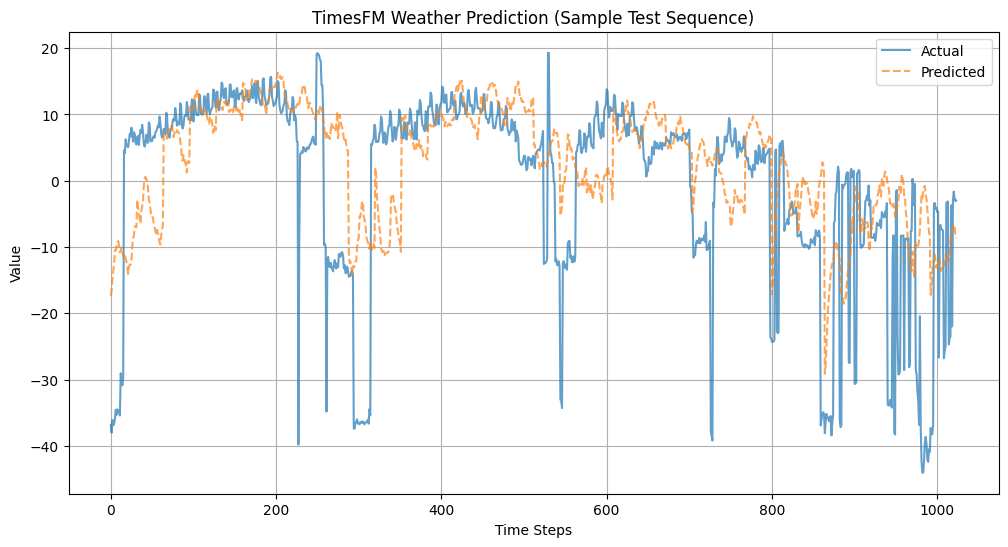

In [ ]:
plot_predictions(
    anomaly_preds,
    anomaly_targets,
    filename="/content/drive/MyDrive/weather_model_runs/anomaly_prediction_plot.png"
)

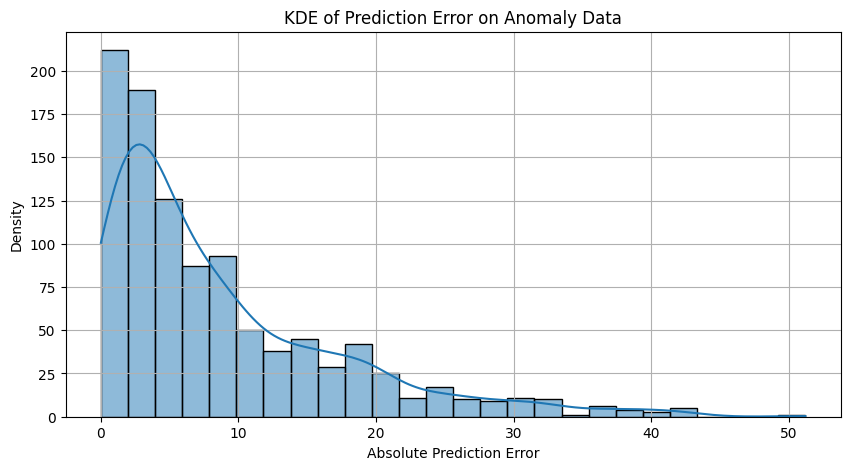

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Use the same error we computed earlier
p = anomaly_preds[0]   # first batch
t = anomaly_targets[0]

pred_series = p[0].flatten()
true_series = t[0].flatten()

error = np.abs(true_series - pred_series)

plt.figure(figsize=(10,5))
sns.histplot(error, fill=True,kde=True) # --> boxplot
plt.title("KDE of Prediction Error on Anomaly Data")
plt.xlabel("Absolute Prediction Error")
plt.ylabel("Density")
plt.grid(True)
plt.show()
